In [90]:
import os
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame, GeoSeries
import numpy as np
from quetzal.model import stepmodel
import matplotlib.pyplot as plt

In [2]:
# Load the model with LoS tables from the last exercise
input_path = './../../input/'
model_path = '../../model/'
sm = stepmodel.read_json(model_path + 'los_tables')

In [3]:
# check for broken GeoDataFrames
broken_gdf_keys = [key for key in sm.__dict__.keys() if type(sm.__dict__[key]) == pd.core.frame.DataFrame and 'geometry' in sm.__dict__[key].columns]
print("Fixing:", broken_gdf_keys)
# fix broken GeoDataFrames
for key in broken_gdf_keys:
    sm.__dict__[key] = gpd.GeoDataFrame(sm.__dict__[key], crs=sm.epsg)
broken_gdf_keys = [key for key in sm.__dict__.keys() if type(sm.__dict__[key]) == pd.core.frame.DataFrame and 'geometry' in sm.__dict__[key].columns]
if len(broken_gdf_keys)>0:
    print("Broken GeoDataFrames:", broken_gdf_keys)
else:
    print("Successfully fixed.")

Fixing: ['checkpoint_links', 'loaded_links', 'links', 'road_links', 'footpaths', 'lines', 'networkcaster_neighbors', 'networkcaster_road_access', 'node_parenthood', 'road_to_transit', 'zone_to_transit', 'zone_to_road', 'checkpoint_nodes', 'loaded_nodes', 'nodes', 'road_nodes', 'centroids', 'disaggregated_nodes', 'micro_zones', 'zones', 'node_clusters']
Successfully fixed.


## Step trip generation
In every zone we need to generate a column `emission` and `attraction`. What kind of trips you count to it largely affects the interpretability of your results. If you use employment characteristics only for attraction, your model will only be applicable to commuting questions, but not for shopping or leisure trips. Moreover, the results of a congestion analysis after the assignment step are worthless because the real network load is higher when you consider all demand segments.

In [4]:
# Start with emission and attraction from commuting purposes
# Assumptions (usually derived from a mobility survey):
employment_rate = 0.7
home_office_rate = 0.1
work_trips_per_day = 1.05 # we set up the model for one average weekday!
sm.zones['emission'] = sm.zones['pop'] * work_trips_per_day * (1-home_office_rate) * employment_rate
sm.zones['attraction'] = sm.zones['emp']

# Now add the shopping purpose (usually derived from a mobility survey)
shopping_trips_per_day = 0.3
attraction_per_POI = sm.zones['pop'].mean() / sm.zones['pois'].mean() * shopping_trips_per_day * 1.8202595
sm.zones['emission'] += sm.zones['pop'] * shopping_trips_per_day
sm.zones['attraction'] += sm.zones['pois'] * attraction_per_POI
print('Total emission:', int(sum(sm.zones['emission'])), 'Total attraction:', int(sum(sm.zones['attraction'])))

Total emission: 3620092 Total attraction: 3620092


Text(0.5, 1.0, 'attraction per zone')

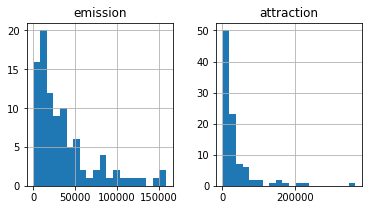

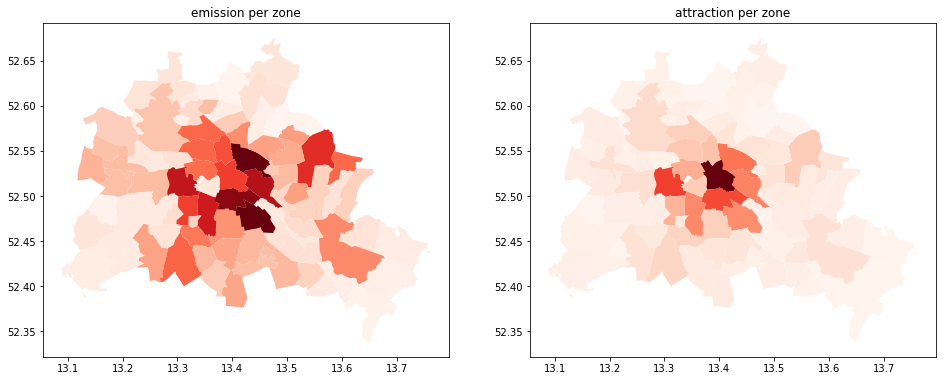

In [5]:
sm.zones[['emission', 'attraction']].hist(bins=20, figsize=(6,3))
fig, ax = plt.subplots(1, 2, figsize=(16,16))
sm.zones.plot(ax=ax.flat[0], column='emission', cmap="Reds")
ax.flat[0].set_title("emission per zone")
sm.zones.plot(ax=ax.flat[1], column='attraction', cmap="Reds")
ax.flat[1].set_title("attraction per zone")


In [6]:
# Now we need to introduce our demand segments.
# Car owners and PT captives is a good start.
# Other common demand segments are trip purposes, income groups, age groups.
sm.segments = ['car_owner', 'pt_captive']
car_ownership = 0.4
sm.zones[('car_owner', 'emission')] = sm.zones['emission'] * car_ownership
sm.zones[('pt_captive', 'emission')] = sm.zones['emission'] * (1-car_ownership)
sm.zones[('car_owner', 'attraction')] = sm.zones['attraction'] * car_ownership
sm.zones[('pt_captive', 'attraction')] = sm.zones['attraction'] * (1-car_ownership)

In [7]:
# Cast columns to integer
sm.zones[('car_owner', 'emission')] = sm.zones[('car_owner', 'emission')].astype(int)
sm.zones[('car_owner', 'attraction')] = sm.zones[('car_owner', 'attraction')].astype(int)
sm.zones[('pt_captive', 'emission')] = sm.zones[('pt_captive', 'emission')].astype(int)
sm.zones[('pt_captive', 'attraction')] = sm.zones[('pt_captive', 'attraction')].astype(int)

In [8]:
# Delete the non-segmented columns to prevent errors
del sm.zones['emission']
del sm.zones['attraction']
sm.zones.sample()

,uuid,sch,nam,gdf,bezeich,pop,popCentroidLat,popCentroidLon,emp,pois,...,hostel,hotel,theme_park,zoo,lake,geometry,"(car_owner, emission)","(pt_captive, emission)","(car_owner, attraction)","(pt_captive, attraction)"
index,,,,,,,,,,,,,,,,,,,,,
zone_25,DEBE04YY50000005,110000040407,Halensee,1266873.0,AX_KommunalesGebiet,15443,52.49675,13.294814,9774.262243,209,...,0,3,0,0,0,"POLYGON ((13.29585 52.50248, 13.29586 52.50245...",5939,8909,8331,12496


## Step distribution

Once we have emission and attraction, we want to know the volumes per OD-pair. We can use the `step_distribution` function from quetzal. It uses the doubly constrained distribution (no probabilistic Logit approach), which is an iterative process where emissions and attractions are matched so that, on average, the minimal resistance for the whole system is found. Talking about resistance: an important input parameter is the impedance matrix, giving resistances between every OD-pair. Resistance can be time, but also cost or other utility/disutility quantifications.

Calibration of this step (not performed in this toy model) requires to change emission and attraction values or the impedance matrix

In [9]:
# Now, we need an impedance matrix for car and PT, respectively.
# Use time as resistance value, but distance or cost are thinkable, too
car_imp_matrix = sm.car_los[['origin', 'destination', 'time']].set_index(
    ['origin','destination']).unstack()
# Assign a resistance for staying in the home cell
car_imp_matrix = car_imp_matrix.replace(0, 120)

car_imp_matrix.head(3)

time                                                      \
destination       zone_0       zone_1      zone_10      zone_11      zone_12   
origin                                                                         
zone_0        120.000000   652.572643  1340.734043   889.103639  1311.281245   
zone_1        689.845643   120.000000  1369.135621   854.452533  1557.876751   
zone_10      1351.824411  1313.595283   120.000000  1085.694280  1164.676813   

                                                                              \
destination      zone_13      zone_14      zone_15      zone_16      zone_17   
origin                                                                         
zone_0        401.582654  1588.671907  1677.607460  2709.917733  1764.968004   
zone_1        941.447777  1756.006007  1826.012285  3143.477424  1981.019452   
zone_10      1511.597488   816.060331   761.278331  3042.608472  1217.552622   

             ...                                                      \
destination  ...      zone_88      zone_89       zone_9      zone_90   
origin       ...                                                       
zone_0       ...  1822.647543  1126.346849  1414.296512  1233.946010   
zone_1       ...  1851.049121   888.434705  1442.698090   973.896809   
zone_10      ...   883.202646  1414.040827   488.884260  1628.885325   

                                                                              \
destination      zone_91      zone_92      zone_93      zone_94      zone_95   
origin                                                                         
zone_0       1356.440283   896.094229  2054.474973  1404.300288  1766.084703   
zone_1       1672.692052   606.715968  2202.879797  1114.922028  1476.706443   
zone_10      2373.560746  1520.763695  1125.564336  1967.588640  2329.373055   

                          
destination      zone_96  
origin                    
zone_0       2471.992068  
zone_1       2925.745328  
zone_10      2885.525555  

[3 rows x 97 columns]

In [10]:
# In the PT case we have to take the minimum time per OD pair,
# because we have multiple routes
pt_imp_matrix = sm.pt_los.groupby(
    ['origin', 'destination']).agg({'time': 'min'}).unstack()

In [11]:
pt_imp_matrix = pt_imp_matrix.replace(0, 120)
pt_imp_matrix.head(3)

time                                                      \
destination       zone_0       zone_1      zone_10      zone_11      zone_12   
origin                                                                         
zone_0        120.000000  1953.994137  2976.009386  2394.476008  2835.003653   
zone_1       2045.710184   120.000000  2907.631318  1903.772692  2910.625584   
zone_10      3060.009386  2997.631318   120.000000  2442.570363  2955.628294   

                                                                              \
destination      zone_13      zone_14      zone_15      zone_16      zone_17   
origin                                                                         
zone_0       1914.455835  3176.075180  4065.366651  5680.832919  3475.205661   
zone_1       2386.077766  3251.697111  4140.988582  5306.912024  3550.827592   
zone_10      3271.050190  2756.699821  2536.287471  5939.427274  3595.830302   

             ...                                                      \
destination  ...      zone_88      zone_89       zone_9      zone_90   
origin       ...                                                       
zone_0       ...  3751.828403  3046.310100  3428.569107  2915.333660   
zone_1       ...  3731.450335  2135.606784  3408.191038  2094.850144   
zone_10      ...  2264.453044  3334.404455  1941.193748  3293.428015   

                                                                              \
destination      zone_91      zone_92      zone_93      zone_94      zone_95   
origin                                                                         
zone_0       2890.199842  2520.297929  3862.752444  3567.454368  3709.206485   
zone_1       3622.546118  1501.594612  3938.374375  2548.751051  2690.503169   
zone_10      4572.561367  3279.641342  3587.377085  3879.548723  4021.300840   

                          
destination      zone_96  
origin                    
zone_0       4394.732924  
zone_1       4976.528077  
zone_10      5115.357565  

[3 rows x 97 columns]

In [12]:
# We can perform the quetzal distribution function for all
# our demand segments simultaniously, saving us post-processing.
# Therefore, we need a dictionary with all parameters
distr_params = {'deterrence_matrix': {'car_owner': car_imp_matrix,
                                      'pt_captive': pt_imp_matrix}}
sm.step_distribution(segmented=True, **distr_params)

sm.volumes.head(3)

car_owner
pt_captive


,origin,destination,car_owner,pt_captive,all
0,zone_0,zone_0,4.409594,2.874139,7.283733
1,zone_0,zone_1,50.518723,109.063304,159.582027
2,zone_0,zone_2,13.575027,18.666310,32.241336


## Step mode choice

For mode choice we apply a nested logit model. In modeling terms, this step can be understood as the "logit" step, because the resulting utilities could also be used to compute the impedance matrix from above. You will see, that the logit step is entirely independent of the volumes and could, thus, be done earlier.

In [13]:
# First, we need parameters for our logit model.
# We define the nesting structure (i.e. choice tree)
# and the beta parameters which should come from a calibration
# using a mobility survey.
sm.preparation_logit(time=-0.00055, # beta_t
                     price=-1, # beta_p
                     transfers=0, # we don't want the number of transfers matter (even though it does sometimes)
                     mode=1, # theta_root
                     pt_mode=0.5, # theta_pt (nest parameter for PT)
                     pt_path=0.1, # theta_path (nest parameter for different paths of one PT option)
                     segments=sm.segments
)
# For nest parameters you should take 1 >= mode >= pt_mode >= pt_path > 0

In [14]:
# Now we have generated the nesting structure table
# Can differ by demand segment, if you want
sm.mode_nests

segment,root,car_owner,pt_captive
route_type,,,
root,NaN,NaN,NaN
subway,pt,pt,pt
bus,pt,pt,pt
rail,pt,pt,pt
car,root,root,root
walk,root,root,root
tram,pt,pt,pt
pt,root,root,root


In [15]:
# And the corresponding theta values
sm.logit_scales

segment,root,car_owner,pt_captive
route_type,,,
root,1.0,1.0,1.0
subway,0.1,0.1,0.1
bus,0.1,0.1,0.1
rail,0.1,0.1,0.1
car,0.0,0.0,0.0
walk,0.0,0.0,0.0
tram,0.1,0.1,0.1
pt,0.5,0.5,0.5


In [16]:
# And the Alternative-Specific-Constants (ASC)
# We have to prevent PT captives from using a car
sm.mode_utility.loc[ 'car', 'pt_captive'] = -100
sm.mode_utility

segment,root,car_owner,pt_captive
route_type,,,
root,0,0,0
subway,0,0,0
bus,0,0,0
rail,0,0,0
car,0,0,-100
walk,0,0,0
tram,0,0,0


In [17]:
# And the beta parameters
# The column 'mode_utility' refers to the weight of the ASC table
# Delete the transfers attribute because we don't want it in our model formulation
sm.utility_values.drop('ntransfers', inplace=True)
sm.utility_values

segment,root,car_owner,pt_captive
value,,,
time,-0.00055,-0.00055,-0.00055
price,-1.00000,-1.00000,-1.00000
mode_utility,1.00000,1.00000,1.00000


In [18]:
# Now, add segment specific ASC column to LoS table.
# But first we have to generate a combined LoS table
sm.los = pd.concat([sm.pt_los, sm.car_los]).reset_index(drop=True)
sm.los['route_types'] = sm.los['route_types'].apply(tuple)# bugfix
sm.analysis_mode_utility(how='main', # how refers to how to calculate the ASC from multiple paths
                         segment=None) # automatically iterates through segments

100%|██████████| 2/2 [00:00<00:00, 12.99it/s]


In [19]:
# Finally, run the logit model
sm.initialize_logit()
# If you want to know what parameters you can give to the function,
# look into the code. You can find the most important functions in
# the quetzal/model/transportmodel.py file, which refers to sub-functions
# by importing them from other quetzal files
sm.step_logit()

100%|██████████| 10/10 [00:03<00:00,  2.89it/s]


In [20]:
# The result is a utilities table
sm.utilities.head(3)

route_type,origin,destination,segment,root,walk,car,pt,tram,rail,bus,subway
0,zone_0,zone_0,car_owner,0.023245,-inf,0.000000,-3.750000,-inf,-inf,-3.750000,-inf
1,zone_0,zone_0,pt_captive,-3.750000,-inf,-100.000000,-3.750000,-inf,-inf,-3.750000,-inf
2,zone_0,zone_1,car_owner,-1.034357,-inf,-1.065582,-4.516451,-inf,-4.755382,-5.012494,-6.866794


In [21]:
# and the probabilities
sm.probabilities.head(3)

route_type,origin,destination,segment,root,walk,car,pt,tram,rail,bus,subway
0,zone_0,zone_0,car_owner,1,0.0,9.770226e-01,0.022977,0.0,0.000000,0.022977,0.000000
1,zone_0,zone_0,pt_captive,1,0.0,1.581817e-42,1.000000,0.0,0.000000,1.000000,0.000000
2,zone_0,zone_1,car_owner,1,0.0,9.692570e-01,0.030743,0.0,0.019064,0.011400,0.000279


In [22]:
# Moreover, you have now probabilities assigned to your paths!
sm.los.head(3)

,origin,destination,gtime,path,reversed,pathfinder_session,broken_modes,boardings,alightings,node_path,...,access_length,footpath_length,in_vehicle_length,length,price,mode_utility,"(car_owner, utility)","(pt_captive, utility)","(car_owner, probability)","(pt_captive, probability)"
0,zone_0,zone_0,0.000000,[zone_0],False,mode_breaker,"[bus, subway, tram, rail]",[],[],[],...,0.000000,0.0,0.0,0.000000,3.75,0,-3.750000,-3.750000,0.022977,1.000000
1,zone_0,zone_25,1114.642785,"[zone_0, n_413, zone_25]",False,mode_breaker,"[bus, subway, tram, rail]",[],[],[n_413],...,2116.839599,0.0,0.0,2116.839599,3.75,0,-4.363054,-4.363054,0.003989,0.132205
2,zone_1,zone_1,0.000000,[zone_1],False,mode_breaker,"[bus, subway, tram, rail]",[],[],[],...,0.000000,0.0,0.0,0.000000,3.75,0,-3.750000,-3.750000,0.022977,1.000000


## Step assignment

This step combines the path probabilities with the volumes and loads them onto the networks.

In [23]:
sm.volumes.head(2)

,origin,destination,car_owner,pt_captive,all
0,zone_0,zone_0,4.409594,2.874139,7.283733
1,zone_0,zone_1,50.518723,109.063304,159.582027


In [24]:
# We want to do an assignment for cars and PT seperately
# (although there is a wrapper function in quetzal)
# Therefore, we must transfer the path probabilities to pt_los and car_los
sm.car_los = sm.los.loc[sm.los['route_type']=='car']
sm.pt_los = sm.los.loc[sm.los['route_type']!='car']

In [25]:
# PT first
sm.segmented_pt_assignment(split_by='route_type', # identify from which route type the load comes
                           on_road_links=False, # load bus traffic to the road network (requires casted networks)
                           path_column='link_path' # pt_los column with the path list
                          )

pt_captive: 100%|██████████| 2/2 [00:07<00:00,  3.99s/it]


In [26]:
# Now cars
sm.segmented_car_assignment()

pt_captive: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


In [27]:
sm.loaded_links.loc[sm.loaded_links['load']!=0].sample()

,trip_id,a,b,link_sequence,time,headway,pattern_id,route_id,service_id,direction_id,...,origin,destination,geometry,road_node_list,road_link_list,"(load, bus)","(load, tram)","(load, subway)","(load, rail)",load
index,,,,,,,,,,,,,,,,,,,,,
link_5996,17352_900_0,n_297,n_445,8,180.0,1200,17352_900_0,17352_900,176,1,...,n_297,n_445,"LINESTRING (13.45839 52.51056, 13.45263 52.51870)",[],[],0.0,3174.229002,0.0,0.0,3174.229002


In [28]:
sm.road_links.loc[sm.road_links[('all', 'car')]!=0].sample()

,a,b,length,time,walk_time,geometry,highway,maxspeed,"(car_owner, car)","(pt_captive, car)","(all, car)"
index,,,,,,,,,,,
106870,164689839,164689840,131.051,9.817907,29.453721,"LINESTRING (13.57057 52.47357, 13.56889 52.47299)",residential,30,1344.098417,3.242314e-39,1344.098417


In [30]:
sm.loaded_links.sample()

,trip_id,a,b,link_sequence,time,headway,pattern_id,route_id,service_id,direction_id,...,origin,destination,geometry,road_node_list,road_link_list,"(load, bus)","(load, tram)","(load, subway)","(load, rail)",load
index,,,,,,,,,,,,,,,,,,,,,
link_706,10224_109_0,n_413,n_434,6,90.0,600,10224_109_0,10224_109,176,0,...,n_413,n_434,"LINESTRING (13.29695 52.48802, 13.29148 52.49636)",[],[],0.0,0.0,0.0,11983.189278,11983.189278


<AxesSubplot:>

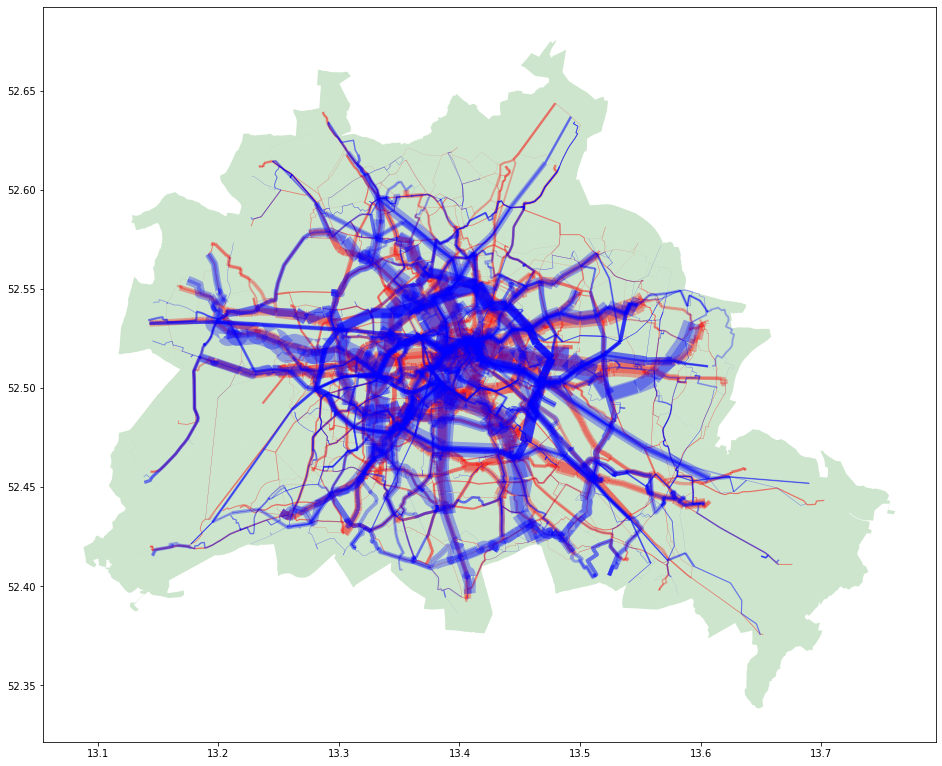

In [32]:
sm.loaded_links = gpd.GeoDataFrame(sm.loaded_links, crs=sm.epsg)
sm.road_links = gpd.GeoDataFrame(sm.road_links, crs=sm.epsg)
scaler = max(sm.loaded_links['load'].max(), sm.road_links[('all', 'car')].max()) / 35

fig, ax = plt.subplots(figsize = (16,16))
sm.zones.plot(ax=ax, alpha=.2, color='green')
sm.road_links.plot(ax=ax, alpha=.3, color='red', linewidth=list(sm.road_links[('all', 'car')]/scaler))
sm.loaded_links.plot(ax=ax, alpha=.3, color='blue', linewidth=list(sm.loaded_links['load']/scaler))

# sm.loaded_links.plot(alpha=.3, color='blue', linewidth=list(sm.loaded_links['load']/scaler),
#     ax=sm.road_links.plot(alpha=.3, color='red', linewidth=list(sm.road_links[('all', 'car')]/scaler),
#         ax=sm.plot('zones', alpha=.2, color='green', figsize=(16,16))))

## Read in validation data

,link_id,elem_nr,vnp,nnp,vst,bst,vricht,ebene,str_typ,strklasse1,strklasse,strklasse2,str_name,bezirk,stadtteil,dtvw_kfz,dtvw_lkw,geometry
8306,67410002_67410003,67410002_67410003.01,67410002.0,67410003.0,0.0,34.0,B,0.0,S,II,G,STRA,Gosener Landstraße,Treptow-Köpenick,Müggelheim,6600.0,170.0,"LINESTRING (13.71239 52.39804, 13.71253 52.397..."


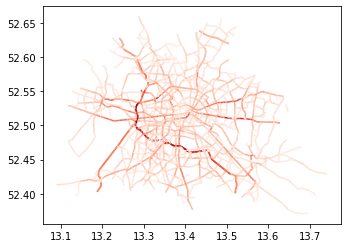

In [36]:
traffic_validation = gpd.read_file(input_path + "validation/Verkehrsmengen.shp")
traffic_validation.to_crs(epsg=4326, inplace=True)
traffic_validation.plot(cmap="Reds", column='dtvw_kfz')
traffic_validation.sample(1)


<AxesSubplot:>

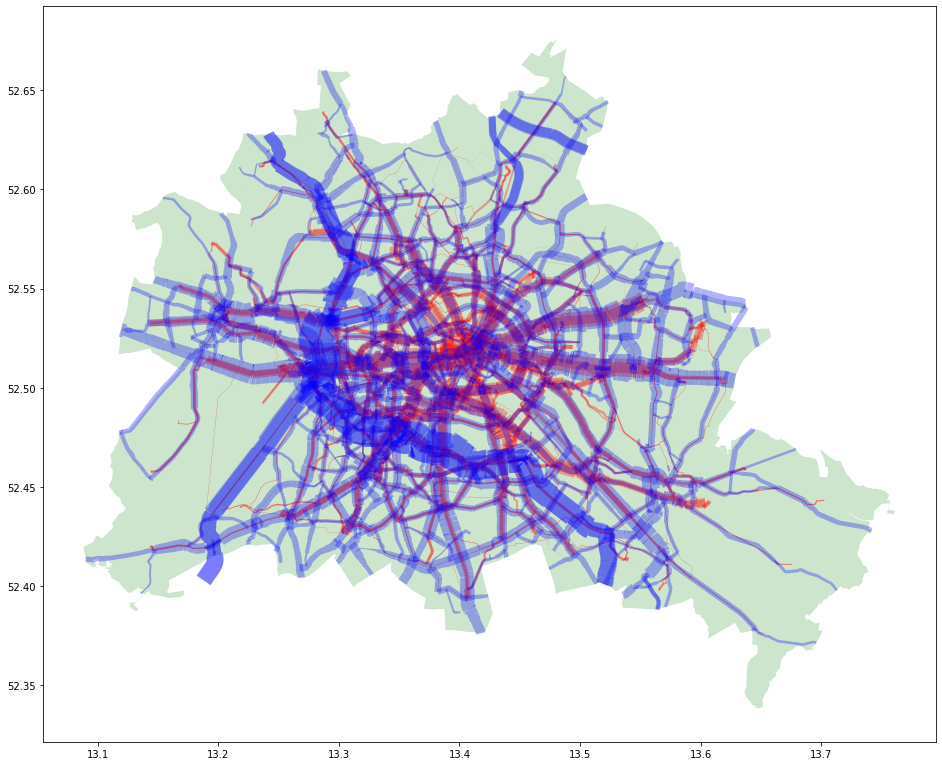

In [43]:
scaler_v = traffic_validation['dtvw_kfz'].max() / (35*4)


fig, ax = plt.subplots(figsize = (16,16))
sm.zones.plot(ax=ax, alpha=.2, color='green')
sm.road_links.plot(ax=ax, alpha=.3, color='red', linewidth=list(sm.road_links[('all', 'car')]/scaler))
traffic_validation.plot(ax=ax, alpha=.3, color="blue", linewidth=list(traffic_validation['dtvw_kfz']/scaler))


<AxesSubplot:>

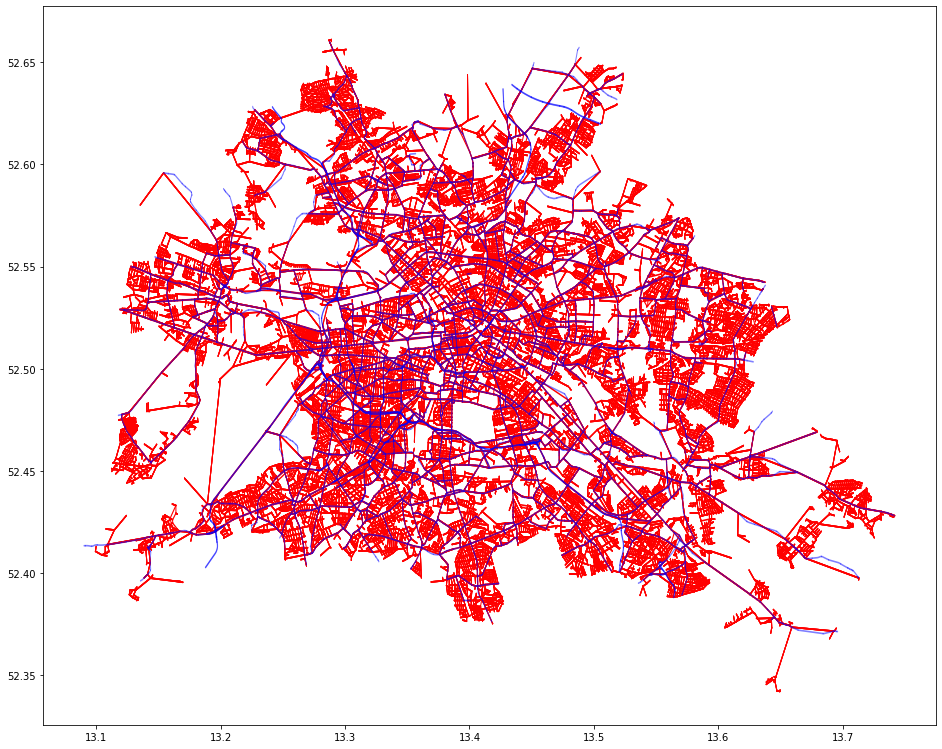

In [55]:
fig, ax = plt.subplots(figsize = (16,16))
# traffic_validation.plot(ax=ax, alpha=.3, column ='dtvw_kfz', cmap='viridis')
# traffic_validation.buffer(0.001).sample(100).plot(ax=ax, color="blue")
# sm.road_links.buffer(0.001).sample(100).plot(ax=ax, color="red")
sm.road_links.buffer(0.0004).plot(ax=ax, color="red")
traffic_validation.buffer(0.0004).plot(ax=ax, color="blue", alpha=0.5)


In [68]:
# for each link in road network compute its validation traffic data by:

network_buff = sm.road_links.buffer(0.0004)
validation_buff = traffic_validation.buffer(0.0004)
print(type(network_buff))


<class 'geopandas.geoseries.GeoSeries'>


In [89]:
traffic_validation.sample()

,link_id,elem_nr,vnp,nnp,vst,bst,vricht,ebene,str_typ,strklasse1,strklasse,strklasse2,str_name,bezirk,stadtteil,dtvw_kfz,dtvw_lkw,geometry
457,38500007_38500008,38500007_38500008.01,38500007.0,38500008.0,0.0,54.0,B,0.0,S,III,G,STRA,Berkaer Straße,Charlottenburg-Wilmersdorf,Schmargendorf,7100.0,140.0,"LINESTRING (13.28479 52.47999, 13.28507 52.479..."


In [85]:
# way too slow apply grid search.


intersections = network_buff[0:len(network_buff)//1000].apply(lambda g: [(n, x.area) for n,x in enumerate(validation_buff.intersection(g)) if not x.is_empty])
total_intersection_areas = [sum([y for n, y in x]) for x in intersections]
dtvw_kfz = [sum([y/t*traffic_validation.iloc[n]['dtvw_kfz'] for n,y in x]) for x,t in zip(intersections, total_intersection_areas)] 
# for each link in road network with buffer calculate retrieve its intersection with validation data gdf
# now weight the intersection by area / divide by total intersection number and multiply it with respective validation data point

# normalize total traffic at some point

margin_x = max([x.bounds[2]-x.bounds[0] for x in sm.road_links['geometry']])
margin_y = max([x.bounds[3]-x.bounds[1] for x in sm.road_links['geometry']])

In [ ]:
def toggleMetersToDegrees (coord:tuple=(0,0), lat:float=52.5, outputUnit=["meters", "degrees"][1]):
    """
    transform meters to degrees and vice versa
    """
    # s
    r_earth = 6378 #*1000
    #theta is the latitude in degrees 
    theta = lat
    #The number of kilometers per degree of longitude is approximately
    lonkm = (math.pi/180) * r_earth * math.cos(theta*math.pi/180)
    #The number of kilometers per degree of latitude is approximately the same at all locations, approx
    latkm = (math.pi/180) * r_earth

    projection_rescale = (coord[0]/(lonkm*1000), coord[1]/(latkm*1000)) if outputUnit in "degrees" else (coord[0]*(lonkm*1000), coord[1]*(latkm*1000))

    return projection_rescale

In [ ]:
def gridSearchIntersections (
        intersectionOf:GeoDataFrame, 
        intersectionWith:GeoSeries, 
        gridDimensions:tuple=(1,1), 
        outsideMarginInMeters:float=100, 
        insideBufferInMeters:float=10, 
        outerBox:tuple=None, 
        method:str="intersection",
        plot=True,
        savePlotTo:str="",
        additionaLPlotLayers=[]
        ) -> GeoDataFrame:
    """
    Function that speeds up the search for an array of polygon within a GeoDataFrame
    returns GeoDataFrame with original geometry replaced with intersections geometry
    
    outerBox = (min_x, min_y, max_x, max_y)
    insideBufferInMeters should be at least circle radius around if looking for intersection of circles with something
    """
    # divide sidewalk area into 100 subpolygons
    
    if type(outerBox) == bool:
        outerBox = intersectionWith.total_bounds
    
    outerBoxPoly = Polygon([(outerBox[0], outerBox[1]), (outerBox[2], outerBox[1]), (outerBox[2], outerBox[3]), (outerBox[0], outerBox[3])])

    margin = toggleMetersToDegrees((outsideMarginInMeters, outsideMarginInMeters), lat = 52.5, outputUnit="deg")
    
    outerBoxPolyMargin = Polygon([\
        (outerBox[0]+margin[0], outerBox[1]+margin[1]), (outerBox[2]-margin[0], outerBox[1]+margin[1]), \
        (outerBox[2]-margin[0], outerBox[3]-margin[1]), (outerBox[0]+margin[0], outerBox[3]-margin[1])\
        ])
    
    mx, my = (outerBox[2]-outerBox[0]-2*margin[0])/gridDimensions[0],  (outerBox[3]-outerBox[1]-2*margin[1])/gridDimensions[1]

    padding = toggleMetersToDegrees((insideBufferInMeters, insideBufferInMeters), lat = 52.5, outputUnit="deg")

    xsteps = [margin[0]+outerBox[0]+mx*(n) for n in range(gridDimensions[0]+1)]
    ysteps = [margin[1]+outerBox[1]+my*(n) for n in range(gridDimensions[1]+1)]
    print("set up grid cells")

    grid = [[] for i in range(gridDimensions[0])]
    gridPolys = []

    startTime = datetime.now()
    for i in range(gridDimensions[0]):
        if i in [round(((x*10)//gridDimensions[0])*gridDimensions[0]/10) for x in range(gridDimensions[0])]:
            print("i",i)
        gridCol = intersectionWith.cx[xsteps[i] : xsteps[i+1], : ]
        for j in range(gridDimensions[1]):

            gridCell = gridCol.cx[ : , ysteps[j] : ysteps[j+1]]
            polys = [item for sublist in [list(x) if type(x)==MultiPolygon else [x] for x in gridCell] for item in sublist]
            
            try:
                mlt = cascaded_union(polys) 
            except:
                print("no cascaded union",i,j)
                mlt = MultiPolygon(polys) 
            
            
            grid[i].append(mlt) 

            if plot:
                gridPolys.append(Polygon([\
                    (xsteps[i]-padding[0], ysteps[j]-padding[1]), \
                    (xsteps[i]-padding[0], ysteps[j+1]+padding[1]), \
                    (xsteps[i+1]+padding[0], ysteps[j+1]+padding[1]), \
                    (xsteps[i+1]+padding[0], ysteps[j]-padding[1])\
                ]))
    
    print(datetime.now() - startTime, "time spent to set up grid cells",gridDimensions)

    startTime = datetime.now()

    intersection_df = intersectionOf.copy()
    intersectionPolygons = []
    gridCounter = [0 for i in range(gridDimensions[0]*gridDimensions[1])]
    invalids = []

    for n in range(len(intersectionOf)):
        if (n*100 / len(intersectionOf)) % 10 == 0:
            print(round(100*n/ len(intersectionOf)), "% Time remaining:", (datetime.now()-startTime)*(1-n/ len(intersectionOf)))
        geom = intersectionOf["geometry"].iloc[n]
        if not geom == None and outerBoxPolyMargin.contains(geom.centroid):
            try:
                centroidCoords = geom.centroid.coords[0]
                
                i = next(n for n,x in enumerate(xsteps) if x>centroidCoords[0]) -1
                j = next(n for n,y in enumerate(ysteps) if y>centroidCoords[1]) -1
                
                if method in "intersection":
                    intersection = geom.intersection(grid[i][j])
                elif method in "difference":
                    intersection = geom.difference(grid[i][j])
                
                u = cascaded_union(intersection)
                intersectionPolygons.append(u)    
                gridCounter[i*gridDimensions[1]+j] += 1
            
            except:
                try:
                    centroidCoords = geom.centroid.coords[0]
                    
                    i = next(n for n,x in enumerate(xsteps) if x>centroidCoords[0]) -1
                    j = next(n for n,y in enumerate(ysteps) if y>centroidCoords[1]) -1
                    
                    if method in "intersection":
                        intersection = geom.intersection(grid[i][j])
                    elif method in "difference":
                        intersection = geom.difference(grid[i][j])
                    
                    
                    intersectionPolygons.append(u)    
                    gridCounter[i*gridDimensions[1]+j] += 1
                    if type(intersection) == GeometryCollection:

                        # get all polygons
                        shapes = []
                        for shape in intersection:
                            if type(shape) in [Polygon, MultiPolygon]:
                                shapes.append(shape)
                        try:
                            u = cascaded_union(shapes)
                        except:
                            u = MultiPolygon(shapes)
                    elif type(intersection) == Polygon:
                        intersection = MultiPolygon(intersection)
                    elif type(intersection) == MultiPolygon:
                        intersection = intersection
                    else:
                        intersection = Polygon()
                
                except:
                    # potentially try to fix invalid shape and retry
                    intersectionPolygons.append(Polygon())
                    invalids.append(n)
        else:
            intersectionPolygons.append(Polygon())
    
    intersection_df["geometry"] = intersectionPolygons

    print(datetime.now() - startTime, "time spent to create intersection",len(intersectionOf))
    print("invalids:",invalids)

    if plot:
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 12))

        GeoSeries([outerBoxPoly], crs=4326).plot(ax=ax.flat[0], color="none", edgecolor="black")
        GeoSeries([outerBoxPolyMargin], crs=4326).plot(ax=ax.flat[0], color="none", edgecolor="black")
        
        # selet gridPoly with most points within
        gridMaxIndex = max(range(len(gridCounter)), key=gridCounter.__getitem__)
        GeoSeries(gridPolys[gridMaxIndex:gridMaxIndex+1], crs=4326).plot(ax=ax.flat[1], facecolor="none", edgecolor="blue")
        
        intersectionWith.plot(ax=ax.flat[0], color="pink")
        intersectionWith.plot(ax=ax.flat[1], color="pink")
        
        for (layer, clr) in additionaLPlotLayers:
            if type(layer) not in [GeoSeries, GeoDataFrame]:
                layer = GeoSeries(layer, crs=4326)
            layer.plot(ax=ax.flat[0], color=clr)
            layer.plot(ax=ax.flat[1], color=clr)
        

        intersectionOf.plot(ax=ax.flat[0], color="blue", alpha=0.8)
        intersectionOf.plot(ax=ax.flat[1], color="blue", alpha=0.8)

        
        if any(not x.is_empty for x in intersection_df["geometry"]):
            intersection_df.plot(ax=ax.flat[1], color="green", edgecolor="green")
        else:
            print("empty intersection_df")

        GeoSeries(gridPolys, crs=4326).plot(ax=ax.flat[0], facecolor="none", edgecolor="black", linewidth=0.5)
        
        ax.flat[1].set_xlim(gridPolys[gridMaxIndex].bounds[0]-0.00001, gridPolys[gridMaxIndex].bounds[2]+0.00001)
        ax.flat[1].set_ylim(gridPolys[gridMaxIndex].bounds[1]-0.00001, gridPolys[gridMaxIndex].bounds[3]+0.00001)
        
        if not savePlotTo == "":
            plt.savefig(savePlotTo, dpi=300)      
    #
        
    return intersection_df    

In [71]:
intersections

index
1      [1.2825613667505612e-09, 2.620550786790006e-06...
2      [2.824473715745776e-07, 2.1415029559557267e-06...
3      [7.756862037921883e-07, 7.928761690373788e-07,...
4      [2.2691615371639695e-08, 7.863510894426902e-07...
5      [1.982945008584456e-08, 7.290541512841898e-07,...
                             ...                        
96        [8.528797193106668e-07, 8.297681873783927e-07]
97     [2.235002083445619e-06, 2.71019485693234e-07, ...
98        [7.278655089311233e-07, 7.515579506797793e-07]
99                                                    []
100                                                   []
Length: 100, dtype: object

## Model Results

In [80]:
# Summary of LoS table using a quetzal function
# All attributes are multiplied with path probabilities
od_sum = sm.summary_od(costs=['price', # EUR per person
                              'time', # seconds per ride
                              'in_vehicle_time', # seconds per ride
                              'length', # Meter distance
                              'ntransfers']) # per ride

In [81]:
# Compute passenger kilometer
for seg in sm.segments + ['root']:
    od_sum[(seg, 'pkm')] = od_sum[(seg, 'volume')] * od_sum[(seg, 'length')] / 1000
    # Adjust units of other indicators
    od_sum[(seg, 'in_vehicle_time')] = od_sum[(seg, 'in_vehicle_time')] / 3600
    od_sum[(seg, 'time')] = od_sum[(seg, 'time')] / 3600
    od_sum[(seg, 'length')] = od_sum[(seg, 'length')] / 1000

In [82]:
od_sum.sample(3)

segment                     car_owner                                      \
sum                            volume     price      time in_vehicle_time   
origin  destination mode                                                    
zone_47 zone_52     tram     0.553340  0.034984  0.005640        0.002332   
zone_73 zone_51     car   1182.955880  0.834175  0.174402        0.000000   
zone_60 zone_83     car    103.882158  2.385890  0.454463        0.000000   

segment                                           pt_captive                \
sum                          length ntransfers        volume         price   
origin  destination mode                                                     
zone_47 zone_52     tram   0.098737   0.006997  6.466536e+01  2.646397e+00   
zone_73 zone_51     car    6.951456   0.000000  1.532857e-39  7.344840e-43   
zone_60 zone_83     car   19.882416   0.000000  1.689853e-40  2.262602e-42   

segment                                                 ...             \
sum                               time in_vehicle_time  ... ntransfers   
origin  destination mode                                ...              
zone_47 zone_52     tram  4.266348e-01        0.176426  ...   0.529279   
zone_73 zone_51     car   1.535595e-43        0.000000  ...   0.000000   
zone_60 zone_83     car   4.309789e-43        0.000000  ...   0.000000   

segment                          root                                      \
sum                            volume     price      time in_vehicle_time   
origin  destination mode                                                    
zone_47 zone_52     tram    65.218702  2.624241  0.423063        0.174949   
zone_73 zone_51     car   1182.955880  0.834175  0.174402        0.000000   
zone_60 zone_83     car    103.882158  2.385890  0.454463        0.000000   

segment                                           car_owner    pt_captive  \
sum                          length ntransfers          pkm           pkm   
origin  destination mode                                                    
zone_47 zone_52     tram   7.406503   0.524848     0.054635  4.829879e+02   
zone_73 zone_51     car    6.951456   0.000000  8223.265718  9.382156e-81   
zone_60 zone_83     car   19.882416   0.000000  2065.428262  3.186221e-81   

segment                          root  
sum                               pkm  
origin  destination mode               
zone_47 zone_52     tram   483.042506  
zone_73 zone_51     car   8223.265718  
zone_60 zone_83     car   2065.428262  

[3 rows x 21 columns]

array([<AxesSubplot:ylabel='(car_owner, volume)'>,
       <AxesSubplot:ylabel='(pt_captive, volume)'>], dtype=object)

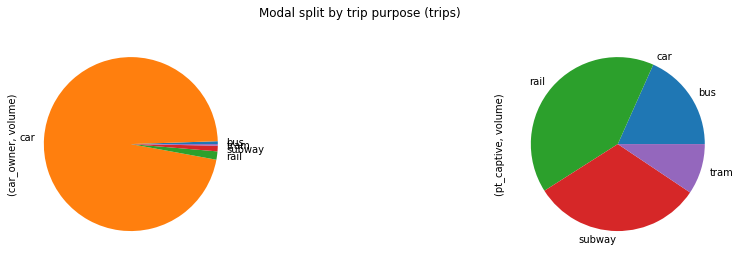

In [83]:
od_sum.loc[:, [(seg, 'volume') for seg in sm.segments]].groupby(level=2).sum().plot.pie(
    subplots=True, figsize=(16, 4), legend=False, title='Modal split by trip purpose (trips)')

array([<AxesSubplot:ylabel='(car_owner, pkm)'>,
       <AxesSubplot:ylabel='(pt_captive, pkm)'>], dtype=object)

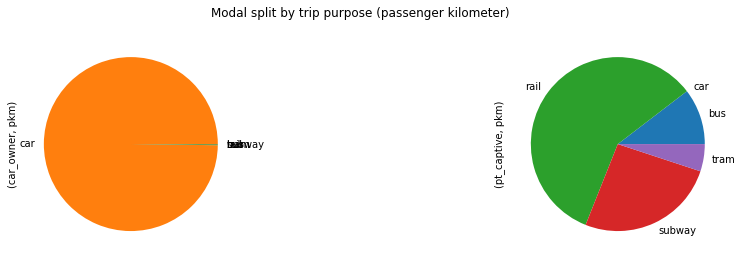

In [84]:
od_sum.loc[:, [(seg, 'pkm') for seg in sm.segments]].groupby(level=2).sum().plot.pie(
    subplots=True, figsize=(16, 4), legend=False, title='Modal split by trip purpose (passenger kilometer)')

## Save model

In [85]:
# Save the od_sum as Excel
if not os.path.exists('../../outputs/'):
    os.makedirs('../../outputs/')
with pd.ExcelWriter('../../outputs/od_summary.xlsx') as writer:  
    od_sum.to_excel(writer, sheet_name='od_sum')

In [86]:
# make sure that all tables have unique indicies before saving
sm.probabilities.reset_index(inplace=True, drop=True)
sm.utilities.reset_index(inplace=True, drop=True)

In [87]:
sm.to_json(model_path + 'four_steps')

to_hdf(overwriting):  60%|██████    | 27/45 [01:19<00:20,  1.13s/it]

could not save geometry from table fare_rules
could not save geometry from table fare_attributes


to_hdf(overwriting): 100%|██████████| 45/45 [01:25<00:00,  1.90s/it]

could not save attribute: parameters
